# Solving a multi-channel CBPDN problem using SPORCO

This notebook demonstrates the use of SPORCO to solve a Convolutional Basis Pursuit DeNoising (CBPDN) problem with a greyscale dictionary and a colour signal

$$\mathrm{argmin}_\mathbf{x} \; (1/2) \sum_c \left\| \sum_m \mathbf{d}_m * \mathbf{x}_{c,m} - \mathbf{s}_c \right\|_2^2 + \lambda \sum_c \sum_m \| \mathbf{x}_{c,m} \|_1$$

where $\mathbf{d}_{m}$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_{c,m}$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter and channel $c$ of the input image, and $\mathbf{s}_c$ is channel $c$ of the input image.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
import sporco.metric as sm
from sporco.admm import cbpdn

%matplotlib inline

Load test image and compute lowpass and highpass components.

In [2]:
# Load test image
img = util.ExampleImages().image('lena', scaled=True, zoom=0.5)

# Highpass filter test image
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load colour dictionary and display it.

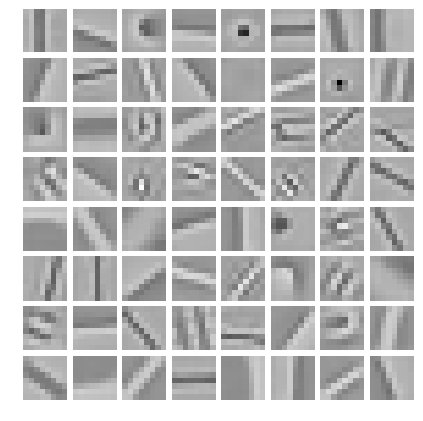

In [3]:
# Load dictionary
D = util.convdicts()['G:8x8x64']

# Display dictionary
fig = plot.figure(figsize=(7,7))
fgax = plot.imview(util.tiledict(D), fgrf=fig)

Set CBPDN solver class options.

In [4]:
# Set up ConvBPDN options
lmbda = 1e-1
opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 200,
                              'LinSolveCheck' : True, 'RelStopTol' : 1e-3,
                              'AuxVarObj' : False})

Initialise and run CBPDN solver and then reconstruct image from sparse representation.

In [5]:
# Solve CBPDN problem
b = cbpdn.ConvBPDN(D, sh, lmbda, opt, dimK=0)
X = b.solve()

print("ConvBPDN solve time: %.2fs" % b.runtime)

# Reconstruct representation
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % sm.psnr(img, imgr))

Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  6.21e+02  7.27e+00  6.14e+03  9.94e-01  3.56e-02  6.00e+00
   1  5.05e+02  3.05e+01  4.75e+03  9.43e-01  1.13e-01  6.00e+00
   2  4.21e+02  5.50e+01  3.66e+03  6.40e-01  2.21e-01  1.22e+01
   3  3.52e+02  7.34e+01  2.79e+03  2.93e-01  2.65e-01  1.47e+01
   4  3.73e+02  7.16e+01  3.02e+03  2.29e-01  2.02e-01  1.10e+01
   5  3.77e+02  6.48e+01  3.12e+03  2.02e-01  1.33e-01  8.24e+00
   6  3.41e+02  6.12e+01  2.79e+03  1.76e-01  1.00e-01  7.18e+00
   7  3.03e+02  6.06e+01  2.43e+03  1.44e-01  7.91e-02  7.18e+00
   8  2.77e+02  6.12e+01  2.16e+03  1.17e-01  6.45e-02  7.18e+00
   9  2.63e+02  6.23e+01  2.01e+03  9.52e-02  5.35e-02  7.18e+00
  10  2.54e+02  6.31e+01  1.91e+03  7.81e-02  4.58e-02  7.18e+00
  11  2.46e+02  6.36e+01  1.83e+03  6.50e-02  4.06e-02  7.18e+00
  12  2.42e+02  6.38e+01  1.78e+03  5.91e-02  3.65e-02  6.42e+00
  13  2.39e+02  6.38e+0

Display low pass component and sum of absolute values of coefficient maps of highpass component.

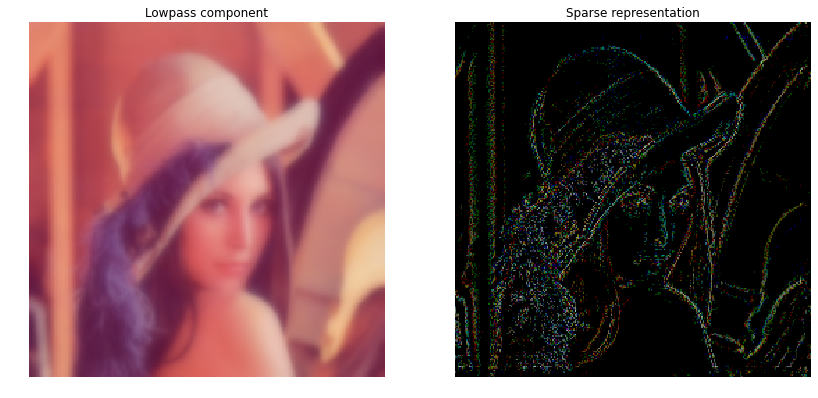

In [6]:
gamma = lambda x, g: x**g
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(sl, title='Lowpass component', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(gamma(np.sum(abs(X), axis=b.cri.axisM).squeeze(), 0.4),
            title='Sparse representation', fgrf=fig)

Display original and reconstructed images.

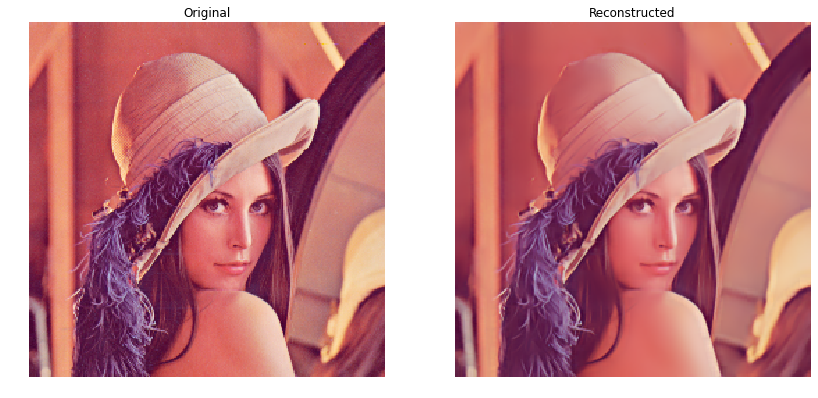

In [7]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(img, title='Original', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(imgr, title='Reconstructed', fgrf=fig)

Plot functional evolution during ADMM iterations.

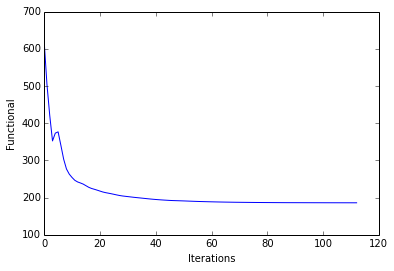

In [8]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

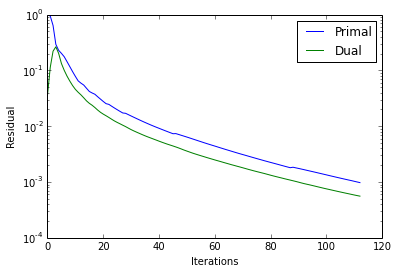

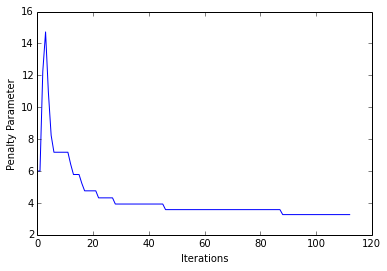

In [9]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual']);
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()